# SVM Modeling
- Ignoring data before 2006.
- Using only type=5 examples.
- No feature selection.
- Param tuning.

In [1]:
import pandas as pd
import numpy as np
import os 

import plotly.plotly as py
import plotly.graph_objs as go

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

In [2]:
# Private DataSet path: ../input/kddbr2018dataset/kddbr-2018-dataset/dataset. This dataset is the same of competitions
#
path = '../input/'
print(os.listdir(path))

['field-22.csv', 'field-20.csv', 'sample-submission.csv', 'field-3.csv', 'soil_data.csv', 'field-18.csv', 'field-23.csv', 'field-17.csv', 'field-2.csv', 'field-27.csv', 'field-24.csv', 'field-10.csv', 'field-11.csv', 'field-26.csv', 'field-21.csv', 'test.csv', 'field-25.csv', 'field-19.csv', 'field-7.csv', 'field-15.csv', 'field-8.csv', 'field-12.csv', 'field-0.csv', 'field-1.csv', 'field-14.csv', 'train.csv', 'field-5.csv', 'field-16.csv', 'field-13.csv', 'field-9.csv', 'field-6.csv', 'field-4.csv']


## Train and test datasets

Basic data containing palm tree information

In [3]:
df_train = pd.read_csv(os.path.join(path, 'train.csv'))

# Ignoring date before 2006
df_train = df_train[df_train.harvest_year >= 2006]

# Using only examples with type=5
df_train = df_train[df_train.type == 5]

df_test  = pd.read_csv(os.path.join(path, 'test.csv'))
df_all = pd.concat([df_train, df_test], sort=False)

print(df_train.shape, df_test.shape, df_all.shape)
df_all.head()

(3332, 7) (4110, 6) (7442, 7)


,Id,field,age,type,harvest_year,harvest_month,production
24,24,0,21,5,2006,1,0.121454
25,25,0,21,5,2006,2,0.073829
26,26,0,21,5,2006,3,0.053183
27,27,0,21,5,2006,4,0.031207
28,28,0,21,5,2006,5,0.067851


In [4]:
def to_date(df):
    return pd.to_datetime((df.harvest_year*10000+df.harvest_month*100+1)\
                                  .apply(str),format='%Y%m%d')
# Add date variable 
for d in [df_train, df_test, df_all]:
    d['date'] = to_date(d)

## Field data (field_*.csv)

These files hold atmospheric data from January 2002 to December 2017, and can be used to estimate the weather conditions during the development of the plant. Notice that weather does influence the production. Using only a single month prior to harvest is probably too little data. Participants should decide how far back in the past they want to look when training models.



In [5]:
# read
df_field = pd.read_csv(path+'field-0.csv')
df_field['field'] = 0
for i in range(1, 28):
    _df_field = pd.read_csv(path+'field-{}.csv'.format(i))
    _df_field['field'] = i
    df_field = pd.concat([df_field, _df_field])

# remove duplicates
df_field = df_field.drop_duplicates()

# Group 
df_field = df_field.groupby(['month', 'year', 'field']).mean().reset_index()
print(df_field.shape)
df_field.head()

(5376, 11)


,month,year,field,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation
0,1,2002,0,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55
1,1,2002,1,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55
2,1,2002,2,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55
3,1,2002,3,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55
4,1,2002,4,26.008,24.434,1.8453,0.32984,0.32597,0.31477,0.29513,361.55


In [6]:
# df_all
df_all = pd.merge(df_all, df_field, left_on=['harvest_year', 'harvest_month','field'], 
                  right_on=['year', 'month', 'field'], how='inner').reset_index()
print(df_all.shape)
df_all.head()

(7442, 19)


,index,Id,field,age,type,harvest_year,harvest_month,production,date,month,year,temperature,dewpoint,windspeed,Soilwater_L1,Soilwater_L2,Soilwater_L3,Soilwater_L4,Precipitation
0,0,24,0,21,5,2006,1,0.121454,2006-01-01,1,2006,26.595,24.740,1.9897,0.34587,0.34462,0.33994,0.32083,341.51
1,1,2351,0,4,5,2006,1,0.018644,2006-01-01,1,2006,26.595,24.740,1.9897,0.34587,0.34462,0.33994,0.32083,341.51
2,2,4226,0,6,5,2006,1,0.100588,2006-01-01,1,2006,26.595,24.740,1.9897,0.34587,0.34462,0.33994,0.32083,341.51
3,3,25,0,21,5,2006,2,0.073829,2006-02-01,2,2006,26.204,24.626,2.1281,0.35104,0.35031,0.34861,0.34523,309.01
4,4,2435,0,4,5,2006,2,0.018644,2006-02-01,2,2006,26.204,24.626,2.1281,0.35104,0.35031,0.34861,0.34523,309.01


In [7]:
df_all.columns

Index(['index', 'Id', 'field', 'age', 'type', 'harvest_year', 'harvest_month',
       'production', 'date', 'month', 'year', 'temperature', 'dewpoint',
       'windspeed', 'Soilwater_L1', 'Soilwater_L2', 'Soilwater_L3',
       'Soilwater_L4', 'Precipitation'],
      dtype='object')

In [8]:
# Features i will duplicate with the past months
features = ['temperature', 'dewpoint', 'windspeed', 'Precipitation', 'Soilwater_L1']

# Remove redundant features.
df_all = df_all.drop(columns=['Soilwater_L2', 'Soilwater_L3', 'Soilwater_L4'])

df_group = df_all.groupby(['field', 'date']).mean().reset_index()[['field', 'date', 'production'] + features]
df_group = df_group.sort_values(['field', 'date'])
print(df_group.shape)
df_group.head()

(3750, 8)


,field,date,production,temperature,dewpoint,windspeed,Precipitation,Soilwater_L1
0,0,2006-01-01,0.080229,26.595,24.740,1.9897,341.51,0.34587
1,0,2006-02-01,0.045585,26.204,24.626,2.1281,309.01,0.35104
2,0,2006-03-01,0.059364,26.019,24.734,2.1760,452.42,0.36100
3,0,2006-04-01,0.045729,25.978,24.882,1.5105,516.34,0.36575
4,0,2006-05-01,0.043659,26.171,24.843,1.6832,349.06,0.36109


In [9]:
# Collect shift values of variables in all features time
period = 2

new_features = {}
for f in features:
    new_features[f] = []
    for i in range(1, period):
        new_feature = '{}_{}'.format(f, i)
        new_features[f].append(new_feature)
        df_group[new_feature] = df_group[f].shift(i).fillna(df_group[f].mean())

df_group = df_group.drop(features+['production'], axis=1)
df_group.head()

,field,date,temperature_1,dewpoint_1,windspeed_1,Precipitation_1,Soilwater_L1_1
0,0,2006-01-01,27.483066,23.767851,2.15631,252.966125,0.308294
1,0,2006-02-01,26.595000,24.740000,1.98970,341.510000,0.345870
2,0,2006-03-01,26.204000,24.626000,2.12810,309.010000,0.351040
3,0,2006-04-01,26.019000,24.734000,2.17600,452.420000,0.361000
4,0,2006-05-01,25.978000,24.882000,1.51050,516.340000,0.365750


In [10]:
df_all = df_all.drop(['index', 'month', 'year'], axis=1)
df_all = pd.merge(df_all, df_group, left_on=['field', 'date'], right_on=['field', 'date'], how='inner').reset_index()

print(df_all.shape)
df_all.head()

(7442, 19)


,index,Id,field,age,type,harvest_year,harvest_month,production,date,temperature,dewpoint,windspeed,Soilwater_L1,Precipitation,temperature_1,dewpoint_1,windspeed_1,Precipitation_1,Soilwater_L1_1
0,0,24,0,21,5,2006,1,0.121454,2006-01-01,26.595,24.740,1.9897,0.34587,341.51,27.483066,23.767851,2.15631,252.966125,0.308294
1,1,2351,0,4,5,2006,1,0.018644,2006-01-01,26.595,24.740,1.9897,0.34587,341.51,27.483066,23.767851,2.15631,252.966125,0.308294
2,2,4226,0,6,5,2006,1,0.100588,2006-01-01,26.595,24.740,1.9897,0.34587,341.51,27.483066,23.767851,2.15631,252.966125,0.308294
3,3,25,0,21,5,2006,2,0.073829,2006-02-01,26.204,24.626,2.1281,0.35104,309.01,26.595000,24.740000,1.98970,341.510000,0.345870
4,4,2435,0,4,5,2006,2,0.018644,2006-02-01,26.204,24.626,2.1281,0.35104,309.01,26.595000,24.740000,1.98970,341.510000,0.345870


## Soil Data (soil_data.csv)

Information about the soil on each field.

In [11]:
df_soil = pd.read_csv(path+'soil_data.csv')
print(df_soil.shape)
df_soil.head()

(28, 73)


,field,BDRICM_BDRICM_M,BDRLOG_BDRLOG_M,BDTICM_BDTICM_M,BLDFIE_sl1,BLDFIE_sl2,BLDFIE_sl3,BLDFIE_sl4,BLDFIE_sl5,BLDFIE_sl6,...,SLTPPT_sl5,SLTPPT_sl6,SLTPPT_sl7,SNDPPT_sl1,SNDPPT_sl2,SNDPPT_sl3,SNDPPT_sl4,SNDPPT_sl5,SNDPPT_sl6,SNDPPT_sl7
0,4,200,7,6973,1345,1308,1361,1413,1486,1503,...,21,19,20,47,48,47,42,40,40,39
1,3,200,9,7272,1297,1287,1323,1428,1492,1508,...,23,22,22,44,45,43,40,36,37,36
2,2,200,7,7281,1266,1249,1310,1387,1463,1491,...,21,21,22,46,46,45,40,39,39,39
3,1,200,6,7457,1297,1277,1345,1409,1480,1506,...,21,21,21,46,47,46,42,40,40,40
4,7,200,8,6771,1305,1289,1333,1438,1497,1510,...,22,21,22,44,45,44,40,38,38,37


In [12]:
# Join datasets
df_all_soil = pd.merge(df_all, df_soil, on='field', how='inner')
print(df_all_soil.shape)
df_all_soil.head()

(7442, 91)


,index,Id,field,age,type,harvest_year,harvest_month,production,date,temperature,...,SLTPPT_sl5,SLTPPT_sl6,SLTPPT_sl7,SNDPPT_sl1,SNDPPT_sl2,SNDPPT_sl3,SNDPPT_sl4,SNDPPT_sl5,SNDPPT_sl6,SNDPPT_sl7
0,0,24,0,21,5,2006,1,0.121454,2006-01-01,26.595,...,22,22,23,44,45,44,39,38,37,36
1,1,2351,0,4,5,2006,1,0.018644,2006-01-01,26.595,...,22,22,23,44,45,44,39,38,37,36
2,2,4226,0,6,5,2006,1,0.100588,2006-01-01,26.595,...,22,22,23,44,45,44,39,38,37,36
3,3,25,0,21,5,2006,2,0.073829,2006-02-01,26.204,...,22,22,23,44,45,44,39,38,37,36
4,4,2435,0,4,5,2006,2,0.018644,2006-02-01,26.204,...,22,22,23,44,45,44,39,38,37,36


## Base Model 

Creation of a baseline model to finalize the competition submission pipeline. The idea is to create the most basic for future improvements.

### Custom CV Generator

In [13]:
def cvPerYear(X, y, fromYear, toYear, numTrainYears=0, evalOnlyLast=False):
    # Reset index is necessary to produce correct indexes for numpy arrays.
    X = X.reset_index()
    
    # Validate using sliding window per year.
    for val_year in range(fromYear, toYear):

        # Train split.
        if numTrainYears == 0:
            # Train split using all 'previous' data.
            idxs_train = X[X.harvest_year < val_year].index.values.astype(int)
        else:
            # Train split using 'previous' data up to a limited window.
            idxs_train = X[(X.harvest_year < val_year) & (X.harvest_year >= (val_year - numTrainYears))].index.values.astype(int)
        
        # Test split.
        if evalOnlyLast:
            # Test split composed of 'present' year only.
            idxs_test = X[X.harvest_year == val_year].index.values.astype(int)
        else:
            # Test split composed of 'present and future' data.
            idxs_test = X[X.harvest_year >= val_year].index.values.astype(int)
        
        yield (idxs_train, idxs_test)

In [21]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error, make_scorer

# Exclude test data.
df_train = df_all_soil[~df_all_soil.production.isna()]

# Most important features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Validate
base_model = SVR(kernel='linear', C=1e-4)
#base_model.fit(X_train, y_train)

# Validate using sliding window.
scores = cross_validate(base_model, Xt, y, scoring={'mae': 'neg_mean_absolute_error', 'r2': 'r2'}, 
                        cv=cvPerYear(X, y, 2009, 2012, evalOnlyLast=False), 
                        return_train_score=True)

In [22]:
from pprint import pprint
for k in list(scores.keys()):
    scores['mean_' + k] = scores[k].mean()
pprint(scores)

{'fit_time': array([0.13150883, 0.19137645, 0.33781052]),
 'mean_fit_time': 0.2202319304148356,
 'mean_score_time': 0.10248541831970215,
 'mean_test_mae': -0.08913028401010098,
 'mean_test_r2': 0.3135156964852453,
 'mean_train_mae': -0.077716386259035,
 'mean_train_r2': 0.31493881468102,
 'score_time': array([0.12713957, 0.11094308, 0.06937361]),
 'test_mae': array([-0.08979641, -0.08809925, -0.08949519]),
 'test_r2': array([0.31687556, 0.29232062, 0.33135091]),
 'train_mae': array([-0.07664379, -0.07874364, -0.07776173]),
 'train_r2': array([0.29451104, 0.31199654, 0.33830886])}


### Grid Search

In [24]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

# Exclude test data.
df_train = df_all_soil[~df_all_soil.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Validate
base_model = SVR()

param_distros = {
    'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1],
    'kernel': ['linear'], #, 'poly', 'rbf'],
#    'degree': [2, 3, 4, 5],
#    'gamma': [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(base_model, param_distros, #n_iter=100,
                                 scoring='neg_mean_absolute_error', 
                                 n_jobs=3, iid=True, refit=False, 
                                 cv=cvPerYear(X, y, 2009, 2012, evalOnlyLast=False))

grid_search.fit(Xt, y)

res = pd.DataFrame(grid_search.cv_results_)

/home/eraldo/miniconda2/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/home/eraldo/miniconda2/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/home/eraldo/miniconda2/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning:

You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True

/home/eraldo/miniconda2/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning

In [92]:
cols = [c for c in res.columns if 'train' in c]
cols.append('params')
cols
res2 = res.drop(cols, axis=1)
#res2 = res2[res2.param_kernel == 'linear']
res2.sort_values('mean_test_score', ascending=False).head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_degree,param_kernel,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
24,0.467780,0.128862,0.108737,0.037932,0.0001,2,linear,-0.089796,-0.088099,-0.089495,-0.089180,0.000772,1
33,0.482969,0.165765,0.117443,0.036540,0.0001,5,linear,-0.089796,-0.088099,-0.089495,-0.089180,0.000772,1
30,0.429647,0.132346,0.115213,0.036851,0.0001,4,linear,-0.089796,-0.088099,-0.089495,-0.089180,0.000772,1
27,0.731485,0.235784,0.187607,0.094816,0.0001,3,linear,-0.089796,-0.088099,-0.089495,-0.089180,0.000772,1
71,0.484225,0.158943,0.128017,0.046149,0.1,5,rbf,-0.092920,-0.087176,-0.090384,-0.090582,0.002570,5
68,0.430852,0.168682,0.118983,0.046774,0.1,4,rbf,-0.092920,-0.087176,-0.090384,-0.090582,0.002570,5
65,0.703171,0.033880,0.191742,0.096825,0.1,3,rbf,-0.092920,-0.087176,-0.090384,-0.090582,0.002570,5
62,0.399622,0.189539,0.093152,0.005521,0.1,2,rbf,-0.092920,-0.087176,-0.090384,-0.090582,0.002570,5
64,1.121340,0.664590,0.262219,0.018088,0.1,3,poly,-0.091595,-0.089146,-0.090583,-0.090610,0.001095,9
59,1.241879,0.755204,0.283361,0.186548,0.01,5,rbf,-0.092006,-0.090074,-0.091240,-0.091234,0.000864,10


In [106]:
np.logspace(-20, -1, 20, base=2)

array([9.53674316e-07, 1.90734863e-06, 3.81469727e-06, 7.62939453e-06,
       1.52587891e-05, 3.05175781e-05, 6.10351562e-05, 1.22070312e-04,
       2.44140625e-04, 4.88281250e-04, 9.76562500e-04, 1.95312500e-03,
       3.90625000e-03, 7.81250000e-03, 1.56250000e-02, 3.12500000e-02,
       6.25000000e-02, 1.25000000e-01, 2.50000000e-01, 5.00000000e-01])

In [ ]:
from sklearn.model_selection import validation_curve

# Param C range.
param_range = np.logspace(-20, -1, 20, base=2)

train_scores, test_scores = validation_curve(
    SVR(kernel='linear'), Xt, y, param_name='C', 
    param_range=param_range,
    cv=cvPerYear(X, y, 2009, 2012, evalOnlyLast=False), 
    scoring='neg_mean_absolute_error', n_jobs=3)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

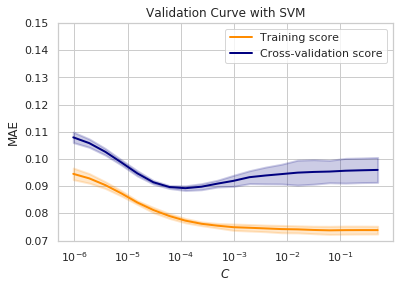

In [110]:
plt.title("Validation Curve with SVM")
plt.xlabel("$C$")
plt.ylabel("MAE")
plt.ylim(0.07, 0.15)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

### Train on all data

In [112]:
# Exclude test data.
df_train = df_all_soil[~df_all_soil.production.isna()]

# All features.
features = list(set(df_train.columns) - set(['production', 'date', 'Id', 'index']))

# Input and output data.
X = df_train[features]
y = df_train.production.values

# Scaling all data.
scaler = StandardScaler()
Xt = scaler.fit_transform(X)

# Train.
base_model = SVR(kernel='linear', C=1e-4)
base_model.fit(Xt, y)

SVR(C=0.0001, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Submission

It makes the predict of the basic model and creates the sample to substrate in kaggle, finishing the complete pipeline

In [113]:
# Get test examples.
df_test = df_all_soil[df_all_soil.production.isna()]

# Important features.
X = df_test[features]

# Normalize input features.
Xt = scaler.transform(X)

# Make prediction.
pred = base_model.predict(Xt)

# Create a submission file.
with open('../submissions/submission-all_data-ignore_lt2006-only_type5-no_ftr_selection-svr_linear_C1e-4.csv', 'w') as f:
    f.write("Id,production\n")
    for _id, _pred in zip(df_test.Id.values, pred):
        f.write("{},{}\n".format(_id, _pred))